# Предобработка данных

In [128]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None #чтобы можно было менять значения одной ячейки в pandas

Поменяем типы данных на подходящие

In [129]:
df = pd.read_csv('https://raw.githubusercontent.com/artsyyyy/python_project_AXA/main/QS_dataframe.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df['Total faculty staff'] = [float(str(x).replace(',', '.')) for x in df['Total faculty staff']] #некоторые значения через запятую были прописаны, поэтому astype не использовать
df.dtypes

rank                               object
name                               object
link                               object
location                           object
points                             object
Total students                    float64
International students            float64
Total faculty staff               float64
International Students Ratio      float64
Citations per Faculty             float64
Employer Reputation               float64
Employment Outcomes               float64
Overall                           float64
International Research Network    float64
International Faculty Ratio       float64
Academic Reputation               float64
Faculty Student Ratio             float64
dtype: object

###  Заполняем пропуски по столбцам

In [130]:
df.isnull().sum()

rank                                0
name                                0
link                                0
location                            2
points                              0
Total students                      3
International students             46
Total faculty staff                 3
International Students Ratio       58
Citations per Faculty               6
Employer Reputation                 2
Employment Outcomes                13
Overall                           921
International Research Network     14
International Faculty Ratio        99
Academic Reputation                 1
Faculty Student Ratio               3
dtype: int64

#### 1) location

In [131]:
df['name'][np.where(df['location'].isnull())[0]]

1091    Sheffield Hallam University
1398             Yuan Ze University
Name: name, dtype: object

Всего лишь у двух университетов не заполнена локация, найдем их локацию и заполним построчно:

In [132]:
df['location'][1091] = 'Sheffield, United Kingdom'
df['location'][1398] = ' Taoyuan City, Taiwan'

In [133]:
df['location'].isnull().sum()

0

#### 2) total students

In [134]:
df['name'][np.where(df['Total students'].isnull())[0]] #смотрим в каких университетах пропущена число студентов

53               City University of Hong Kong
355                City, University of London
634    The University of Tennessee, Knoxville
Name: name, dtype: object

In [135]:
df['name'][np.where(df['Total students'] <= 0)[0]] #следовательно в каких-то университетах ноль стоит

354                       Beijing Institute of Technology
444                      Beihang University (former BUAA)
620          Nanjing University of Science and Technology
812     Beijing University of Posts and Telecommunicat...
821             China University of Mining and Technology
1007                                 Zhengzhou University
1050                     Huazhong Agricultural University
1055                                  Jiangnan University
1230                                     Hohai University
1273                           Shanghai Normal University
1279                                 Southwest University
Name: name, dtype: object

У трех университетов пропущено значение числа студентов, еще у 11 стоят нули, заполним такие значения медианными:

In [136]:
df['Total students'].fillna(df['Total students'].median(), inplace=True)
df['Total students'][np.where(df['Total students'] <= 0)[0]] = df['Total students'].median()

In [137]:
df['Total students'].isnull().sum()

0

#### 3) international students

In [138]:
df['name'][np.where(df['International students'].isnull())[0]].head(5) # здесь только такие пропуски (нулей нет)

53                          City University of Hong Kong
355                           City, University of London
517                            Universidad de Costa Rica
634               The University of Tennessee, Knoxville
688    Universidad Nacional del Centro de la Provinci...
Name: name, dtype: object

In [139]:
cr = np.corrcoef([df['Total students'], df['International students'].fillna(df['International students'].mean())])[0, 1]
print('Корелляция между количеством студентов и количеством иностранных студентов -', cr)

Корелляция между количеством студентов и количеством иностранных студентов - 0.34272760837898797


Корелляция между количеством студентов и количеством иностранных студентов мала, следовательно заполнить пропуски в столбце International students, основываясь на общем количестве студентов неверно.

In [140]:
print('Количество пропущенных значений в столбце International students -',df['International students'].isnull().sum())

Количество пропущенных значений в столбце International students - 46


Всего пропущенных значений в этом столбце - 46, оптимальным решением является удаление университетов, в которых пропущены значения в столбце International students:

In [141]:
df.drop(index=np.where(df['International students'].isnull())[0], inplace=True)

#### 4) удаляем овералл и поинтс за ненадобностью

In [142]:
df.drop(columns=['Overall', 'points'], inplace=True)

In [143]:
df.reset_index(inplace=True)

In [144]:
df.drop(columns='index', inplace=True)


#### 5) International Students Ratio

In [145]:
df['rank'][np.where(df['International Students Ratio'].isnull())[0]]

387          =390
393          =396
504       501-510
520       521-530
544       541-550
617       601-650
813      801-1000
864      801-1000
1044    1001-1200
1209    1201-1400
1252    1201-1400
1304    1201-1400
1353    1201-1400
1370        1401+
1372        1401+
Name: rank, dtype: object

Наиболее оптимальным решением является заполнить пропуски в этом столбце медианным значением, в пределах rank университета:

In [146]:
df['International Students Ratio'].iloc[387] = df['International Students Ratio'].iloc[:500].median()
df['International Students Ratio'].iloc[393] = df['International Students Ratio'].iloc[:500].median()

In [147]:
df['rank'][np.where(df['International Students Ratio'].isnull())[0]]

504       501-510
520       521-530
544       541-550
617       601-650
813      801-1000
864      801-1000
1044    1001-1200
1209    1201-1400
1252    1201-1400
1304    1201-1400
1353    1201-1400
1370        1401+
1372        1401+
Name: rank, dtype: object

In [148]:
for i in np.where(df['International Students Ratio'].isnull())[0]:
    df['International Students Ratio'].iloc[i] = df[df['rank'] == df['rank'].iloc[i]]['International Students Ratio'].median()
    

In [149]:
df['International Students Ratio'].isnull().sum()

0

#### 6) Citations per Faculty

In [150]:
df['name'][np.where(df['Citations per Faculty'].isnull())[0]]

1102    ULACIT - Universidad Latinoamericana de Cienci...
Name: name, dtype: object

Заполним этот пропуск медианным значением этого показателя, в пределах rank этого университета

In [151]:
df['Citations per Faculty'].iloc[1102] = df[df['rank'] == '1001-1200']['Citations per Faculty'].median()

In [152]:
df['Citations per Faculty'].isnull().sum()

0

#### 7) Employer Reputation 

In [153]:
df['name'][np.where(df['Employment Outcomes'].isnull())[0]]

544                           University of Madras
810                          Chandigarh University
912                Universidad Simón Bolívar (USB)
1023                              CEU Universities
1115                     Universidad de Valladolid
1162    University of Warmia and Mazury in Olsztyn
1337                        University of Khartoum
1344                        University of Sarajevo
1353                           Université de Tunis
1367    Sudan University of Science and Technology
1374                Université Mohammed V de Rabat
Name: name, dtype: object

Наиболее оптимальным решением является заполнить пропуски в этом столбце медианным значением, в пределах rank университета:

In [154]:
for i in np.where(df['Employment Outcomes'].isnull())[0]:
    df['Employment Outcomes'].iloc[i] = df[df['rank'] == df['rank'].iloc[i]]['Employment Outcomes'].median()

In [155]:
df['Employment Outcomes'].isnull().sum()

0

#### 8) International Research Network

In [156]:
df['name'][np.where(df['International Research Network'].isnull())[0]]

461                               Universidad de Belgrano
777                     Universidad Católica Andres Bello
874         Pontifícia Universidade Católica de São Paulo
1023                                     CEU Universities
1046    Kazakh Ablai Khan University of International ...
1102    ULACIT - Universidad Latinoamericana de Cienci...
1115                            Universidad de Valladolid
1279                     Universidad Católica de Colombia
1285                            Universidad Metropolitana
1358                                  Youngsan University
Name: name, dtype: object

Наиболее оптимальным решением является заполнить пропуски в этом столбце медианным значением, в пределах rank университета:

In [157]:
df['International Research Network'].iloc[461] = df['International Research Network'].median()

In [158]:
for i in np.where(df['International Research Network'].isnull())[0]:
    df['International Research Network'].iloc[i] = df[df['rank'] == df['rank'].iloc[i]]['International Research Network'].median()

In [159]:
df['International Research Network'].isnull().sum()

0

#### 9) International Faculty Ratio 

In [160]:
df['name'][np.where(df['International Faculty Ratio'].isnull())[0]].head(8)

245                                   Yeshiva University
351                                     Universität Jena
387    Pakistan Institute of Engineering and Applied ...
418                                  Universität Leipzig
476           Martin-Luther-Universität Halle-Wittenberg
520            Beijing University of Chemical Technology
521               Christian-Albrechts-University zu Kiel
522                   Poznan University of Life Sciences
Name: name, dtype: object

Наиболее оптимальным решением является заполнить пропуски в этом столбце медианным значением, в пределах rank университета:

In [161]:
df.iloc[:500]['International Faculty Ratio'].fillna(df.iloc[:500]['International Faculty Ratio'].median(), inplace=True)

In [162]:
for i in np.where(df['International Faculty Ratio'].isnull())[0]:
    df['International Faculty Ratio'].iloc[i] = df[df['rank'] == df['rank'].iloc[i]]['International Faculty Ratio'].median()
    

In [163]:
df['International Faculty Ratio'].isnull().sum()

0

#### 10) Faculty Student Ratio

In [164]:
df['name'][np.where(df['Faculty Student Ratio'].isnull())[0]]

544    University of Madras
Name: name, dtype: object

Заполним этот пропуск медианным значением данного столбца

In [165]:
df['Faculty Student Ratio'].fillna(df['Faculty Student Ratio'].median(), inplace=True)

#### Проверим все ли пропуски заполнены:

In [166]:
df.isnull().sum() 

rank                              0
name                              0
link                              0
location                          0
Total students                    0
International students            0
Total faculty staff               0
International Students Ratio      0
Citations per Faculty             0
Employer Reputation               0
Employment Outcomes               0
International Research Network    0
International Faculty Ratio       0
Academic Reputation               0
Faculty Student Ratio             0
dtype: int64

#### Создадим новые колонки, поменяем индекс и порядок столбцов

In [167]:
df['country'] = [x.split(',')[-1].strip() for x in df['location']]

In [168]:
df = df[['rank', 'name', 'link', 'location','country', 'Total students',
       'International students', 'Total faculty staff',
       'International Students Ratio', 'Citations per Faculty',
       'Employer Reputation', 'Employment Outcomes',
       'International Research Network', 'International Faculty Ratio',
       'Academic Reputation', 'Faculty Student Ratio' ]]

In [169]:
df.drop(columns='rank', inplace=True) #rank съехал, поэтому удалим его 
df.index.rename('rank', inplace= True )

# Визуализация

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns

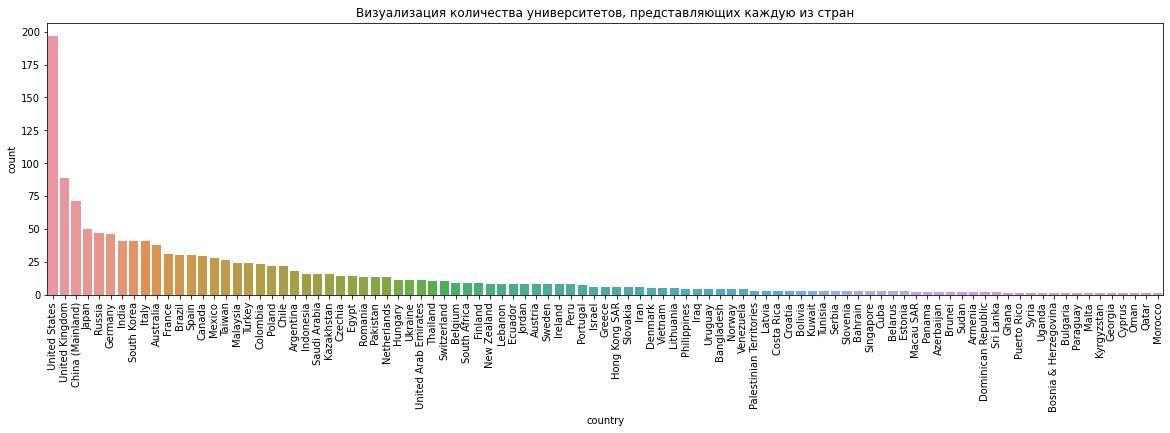

In [171]:
plt.figure(figsize=(20, 5))
sns.countplot(data = df, x = 'country', order=df["country"].value_counts().index)
plt.xticks(rotation=90)
plt.title('Визуализация количества университетов, представляющих каждую из стран');

Соответственно, наибольшее количество университетов в данном рейтинге представляют США, Великобританию, Китай, Японию, Германию и Россию

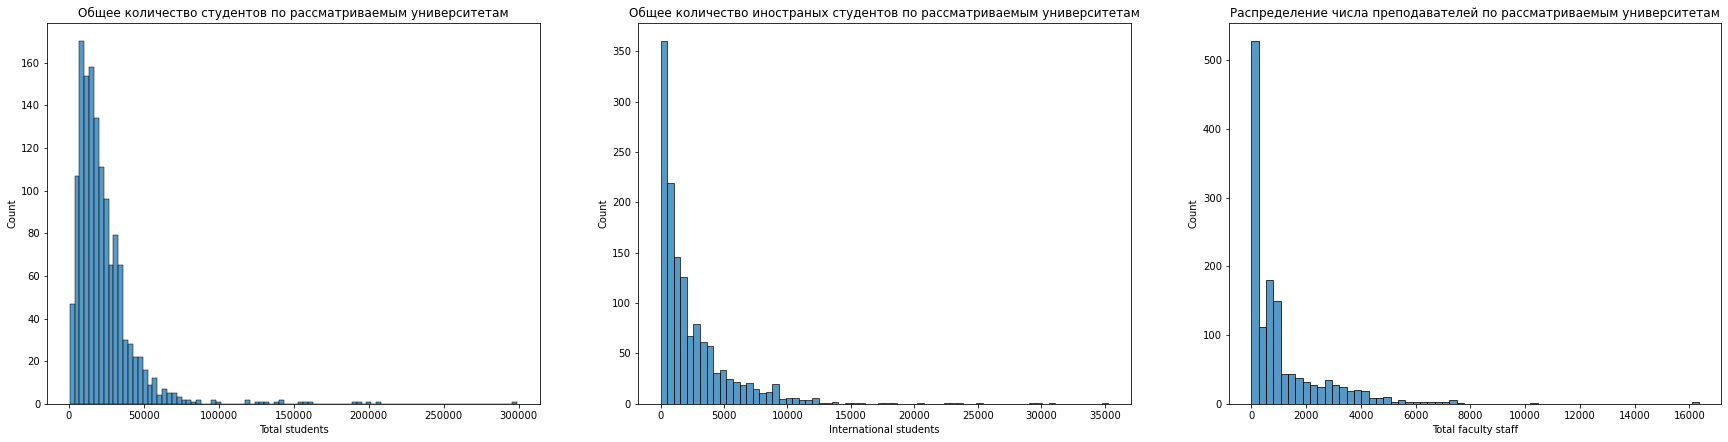

In [172]:
fig, axs = plt.subplots(1, 3, figsize=(30, 7))
sns.histplot(ax=axs[0], data= df,  x = 'Total students')
sns.histplot(ax=axs[1], data= df,  x = 'International students')
sns.histplot(ax=axs[2], data= df,  x = 'Total faculty staff')
axs[0].set (title = 'Общее количество студентов по рассматриваемым университетам' )
axs[1].set (title = 'Общее количество иностраных студентов по рассматриваемым университетам' )
axs[2].set (title = 'Распределение числа преподавателей по рассматриваемым университетам' );


Распределение общего количества студентов визуально похоже на распределение хи квадрат. Распределение количества иностранных студентов визуально похоже на распределение экспоненциальное, как и распределение числа преподавателей



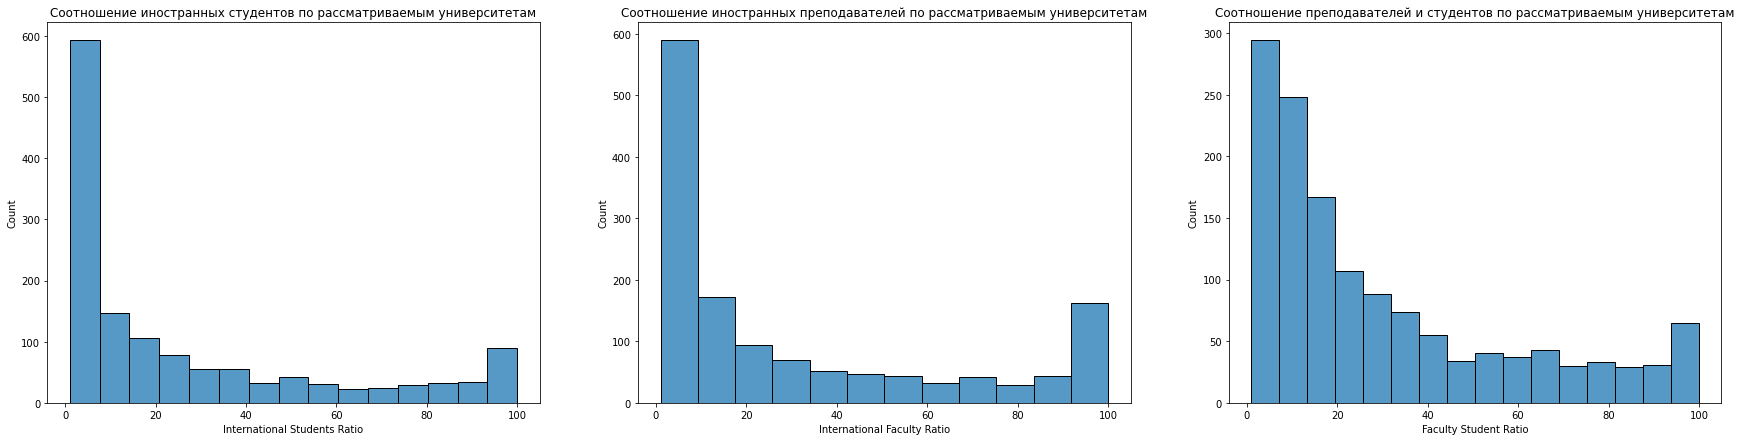

In [173]:
fig, axs = plt.subplots(1, 3, figsize=(30, 7))
sns.histplot(ax=axs[0], data= df,  x = 'International Students Ratio')
sns.histplot(ax=axs[1], data= df,  x = 'International Faculty Ratio')
sns.histplot(ax=axs[2], data= df,  x = 'Faculty Student Ratio')
axs[0].set (title = 'Соотношение иностранных студентов по рассматриваемым университетам' )
axs[1].set (title = 'Соотношение иностранных преподавателей по рассматриваемым университетам' )
axs[2].set (title = 'Соотношение преподавателей и студентов по рассматриваемым университетам' );


Данные соотношения визуально похожи на экспоненциальное распределение как и количество цитирований на каждый факультет

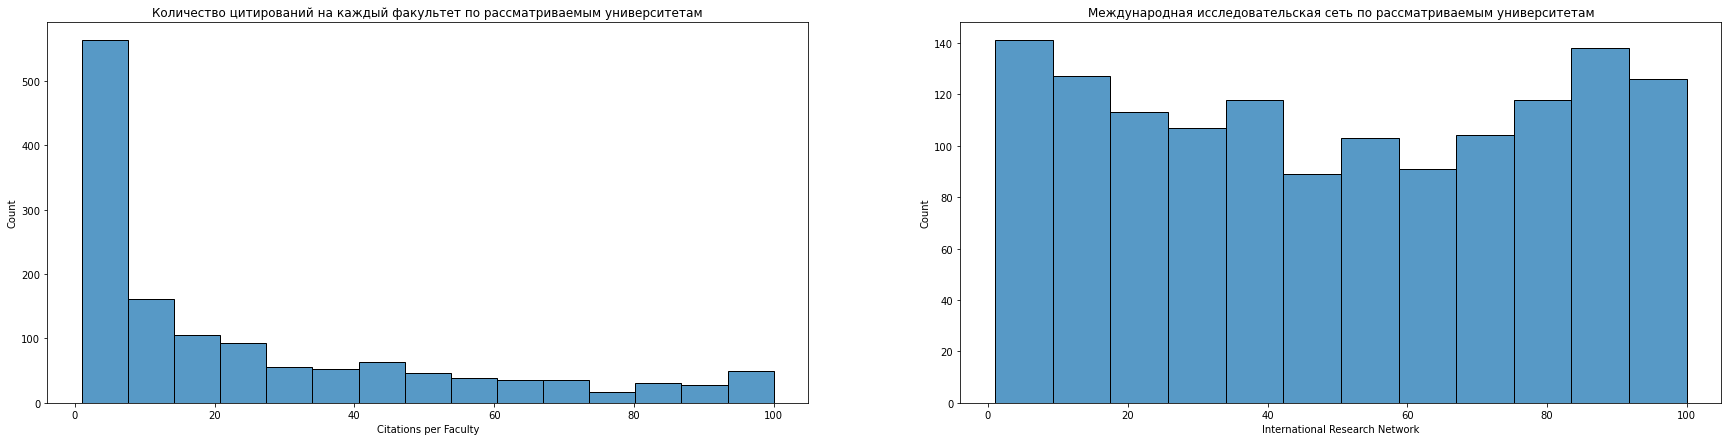

In [174]:
fig, axs = plt.subplots(1, 2, figsize=(30, 7))
sns.histplot(ax=axs[0], data= df,  x = 'Citations per Faculty')
sns.histplot(ax=axs[1], data= df,  x = 'International Research Network')
axs[0].set (title = 'Количество цитирований на каждый факультет по рассматриваемым университетам' )
axs[1].set (title = 'Международная исследовательская сеть по рассматриваемым университетам' );


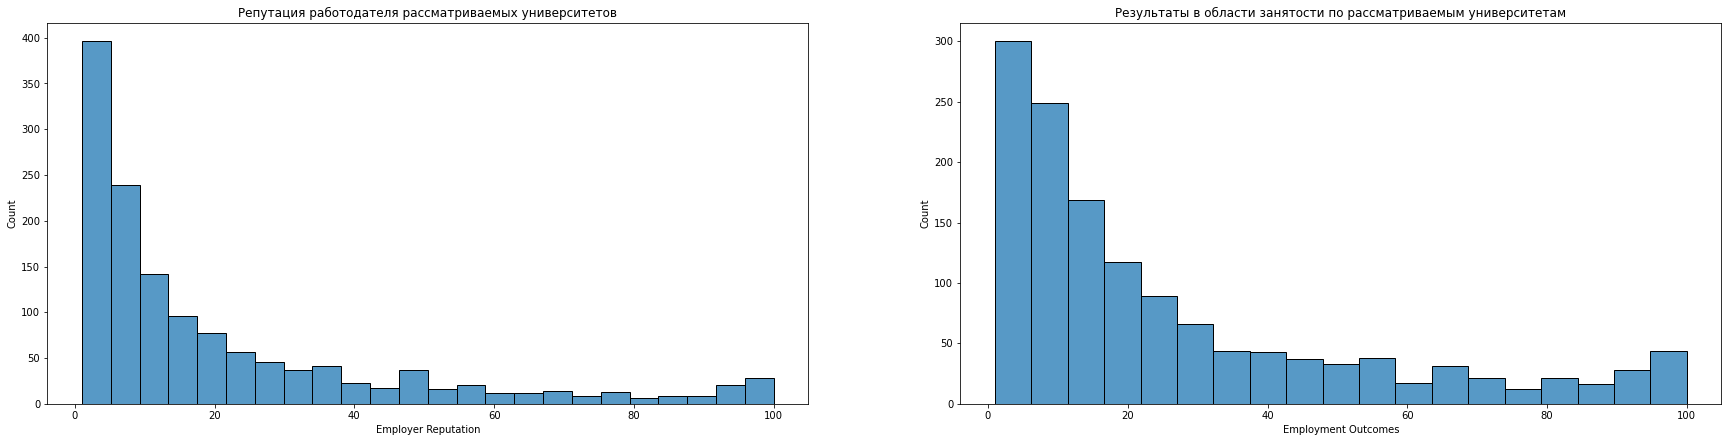

In [175]:
fig, axs = plt.subplots(1, 2, figsize=(30, 7))
sns.histplot(ax=axs[0], data= df,  x = 'Employer Reputation')
sns.histplot(ax=axs[1], data= df,  x = 'Employment Outcomes')
axs[0].set (title = 'Репутация работодателя рассматриваемых университетов' )
axs[1].set (title = 'Результаты в области занятости по рассматриваемым университетам' );


Репутация работодателя рассматриваемых университетов и результаты в области занятости по рассматриваемым университетам визуально похожи на экспоненциальное распределение

In [176]:
a = pd.DataFrame(df.groupby("country")["Academic Reputation"].mean()).sort_values(by = 'Academic Reputation')
a.reset_index(inplace= True )

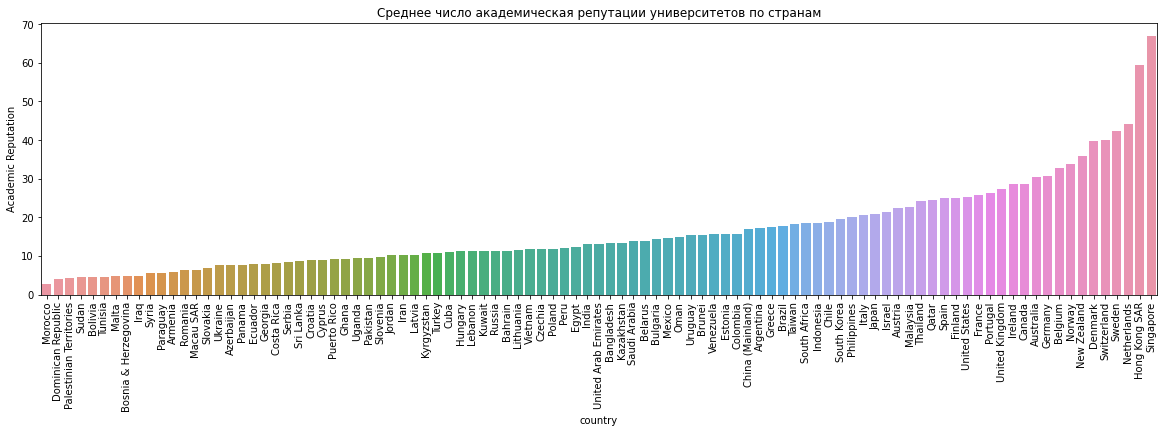

In [177]:
plt.figure(figsize=(20, 5))
sns.barplot(data = a, x = 'country', y = 'Academic Reputation')
plt.xticks(rotation=90)
plt.title('Cреднее число академическая репутации университетов по странам');

Соответственно, наилучшее среднее значение академической репутации университетов у Сингапура, Гонконга,Недерландов.

# Проверка гипотез

Все гипотезы проверяются на уровне значимости 5%

In [178]:
import scipy.stats as sts
import statsmodels

## Первая гипотеза

Пусть part - отношение числа иностранных студентов к числу всех студентов, hse_part - отношение числа иностранных студентов к числу всех студентов в ВШЭ


In [51]:
hse_part = df.loc[308, 'International students']/df.loc[308, 'Total students']
print(f'Отношение числа иностранных студентов к числу всех студентов в ВШЭ - {hse_part}')

Отношение числа иностранных студентов к числу всех студентов в ВШЭ - 0.111820806719748


Основаная гипотеза (H0): математическое ожидание part равно hse_part

Альтернативная гипотеза (Н1): математическое ожидание part не равно hse_part


$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_{part} = hse part = 0.111820806719748 \hspace{2mm}  \\
&H_1: \hspace{2mm} \mu_{part} \neq hse part = 0.111820806719748  \hspace{2mm} 
\end{aligned}
$$

In [54]:
import scipy.stats as sts
import statsmodels

values = (df['International students']/df['Total students']).values
ttest, t_pvalue = sts.ttest_1samp(values, popmean=hse_part,  alternative='two-sided')
if t_pvalue > 0.05:
    print('Согласно t-тесту гипотеза Н0 не отвергается')
else:
    print('Согласно t-тесту гипотеза H0 отвергается')

Согласно t-тесту гипотеза H0 отвергается


Первая гипотеза отвергается. Из интереса построим 95% доверительный интервал

In [56]:
def confid_interval_var_unknown(arr, alpha):
    mean = np.mean(arr)
    var = np.var(arr, ddof=1)
    t_crit = sts.t.ppf(1-(1-alpha)/2, df = len(arr)-1)
    bottom = mean - t_crit*np.sqrt(var/len(arr))
    top = mean + t_crit*np.sqrt(var/len(arr))
    return [bottom, top]


print( f'Доверительный интервал для мат. ожидания part - {confid_interval_var_unknown(values, 0.05)}')

Доверительный интервал для мат. ожидания part - [0.12712455808225168, 0.12756842979589758]


Благодаря большому количеству данных получаем, что математическое ожидание отношения числа иностранных студентов к числу всех студентов ~ 0.127

## Вторая гипотеза

Проверим гипотезу о равенстве математических ожиданий для количества работников в США и России

$$
\begin{aligned}
& H_0: \mu_{USA} = \mu_{Russia} \\
& H_1: \mu_{USA} \neq \mu_{Russia}
\end{aligned}
$$

In [57]:
values_usa = df[df['country'] == 'United States']['Total faculty staff'].values
values_russia = df[df['country'] == 'Russia']['Total faculty staff'].values

Согласно тесту Манна Уитни гипотеза Н0 не отвергается
Согласно t-тесту гипотеза Н0 не отвергается


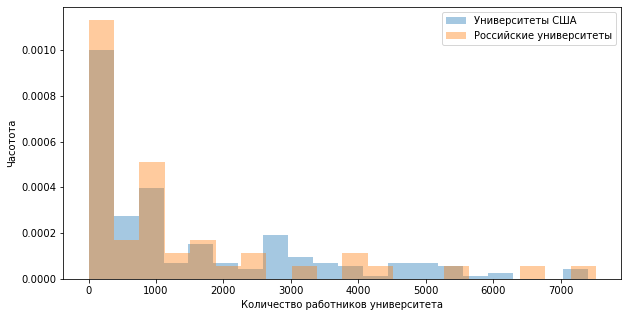

In [58]:
plt.figure(figsize=(10,5))
plt.hist(values_usa, bins=20, density=True, alpha=0.4, label='Университеты США')
plt.hist(values_russia, bins=20, density=True, alpha=0.4, label='Российские университеты')
plt.legend();
plt.xlabel('Количество работников университета');
plt.ylabel('Часотота');

mw_stat, pvalue_mw = sts.mannwhitneyu(values_usa, values_russia, alternative='two-sided')
if pvalue_mw > 0.05:
    print('Согласно тесту Манна Уитни гипотеза Н0 не отвергается')
else:
    print('Согласно тесту Манна Уитни гипотеза H0 отвергается')
    
t_stat, pvalue_t = sts.ttest_ind(values_usa, values_russia, equal_var = False, alternative='two-sided')
if pvalue_t > 0.05:
    print('Согласно t-тесту гипотеза Н0 не отвергается')
else:
    print('Согласно t-тесту гипотеза H0 отвергается')

Так как оба проведенных теста не отвергают основную гипотезу, можно сказать, что в среднем в лучших вузах России и США работает одинаковое количество сотрудников на уровне значимости 5%

## Третья гипотеза

Теперь поговорим о количестве студентов, обучающихся в университетах США и России. Также сделаем предположение о равенстве мат. ожиданий

$$
\begin{aligned}
& H_0: \mu_{USA} = \mu_{Russia} \\
& H_1: \mu_{USA} \neq \mu_{Russia}
\end{aligned}
$$

In [59]:
usa_students = df[df['country'] == 'United States']['Total students'].values
rus_students = df[df['country'] == 'Russia']['Total students'].values

Согласно тесту Манна Уитни гипотеза H0 отвергается
Согласно t-тесту гипотеза H0 отвергается


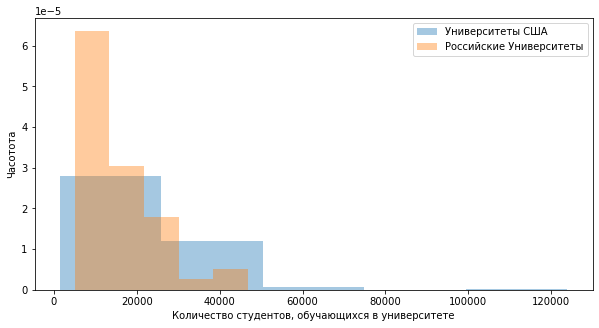

In [60]:
plt.figure(figsize=(10,5))
plt.hist(usa_students, bins=5, density=True, alpha=0.4, label='Университеты США')
plt.hist(rus_students, bins=5, density=True, alpha=0.4, label='Российские Университеты')
plt.legend();
plt.xlabel('Количество студентов, обучающихся в университете');
plt.ylabel('Часотота');

mw_stat, pval_mw = sts.mannwhitneyu(usa_students, rus_students, alternative='two-sided')
if pval_mw > 0.05:
    print('Согласно тесту Манна Уитни гипотеза Н0 не отвергается')
else:
    print('Согласно тесту Манна Уитни гипотеза H0 отвергается')
    
t_stat, pval_t = sts.ttest_ind(usa_students, rus_students, equal_var = False, alternative='two-sided')
if pval_t > 0.05:
    print('Согласно t-тесту гипотеза Н0 не отвергается')
else:
    print('Согласно t-тесту гипотеза H0 отвергается')

Так как оба теста отвергают основную гипотезу, нельзя сделать вывод о том, что в среднем студентов в российских вузах столько же сколько в вузах США

## Четвертая гипотеза

Это скорее не гипотеза, а построение корряляционной матрицы. Интересно, можно ли сказать, какая связь существует между качеством университета и количеством обучающихся и работающих в нем людей. Возьмем эти три признака, так как остальные числовые признаки точно говорят о сильной линейной связи (так как это расбаловка от 0 до 100 баллов - чем выше, тем лучше вуз). Для этого

In [61]:
df['rank'] = df.index
(-1)*df[['Total students', 'Total faculty staff', 'International students', 'rank']].corr().loc['rank'].drop('rank')

Total students           -0.003944
Total faculty staff       0.630167
International students    0.473531
Name: rank, dtype: float64

Наиболее сильная положительная линейная связь с рангом у количества персонала университета. На втором месте идет количество иностранных студентов. А вот у количества студентов и ранга университета корреляция ~0, следовательно не существует линейной связи между этими показателями

# Машинное обучение

In [ ]:
import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, DecisionTreeClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

In [62]:
data = df

In [63]:
groups = []
for i in range(6):
    groups.append((i+1)*(data.shape[0]-1)/6)
groups

[229.0, 458.0, 687.0, 916.0, 1145.0, 1374.0]

In [64]:
data['group'] = [1]*1375

In [65]:
for i in range(5):
    data.loc[ groups[i] < data['rank'], 'group' ] = i+2
data.head(3)

,name,link,location,country,Total students,International students,Total faculty staff,International Students Ratio,Citations per Faculty,Employer Reputation,Employment Outcomes,International Research Network,International Faculty Ratio,Academic Reputation,Faculty Student Ratio,rank,group
rank,,,,,,,,,,,,,,,,,
0,Massachusetts Institute of Technology (MIT),https://www.topuniversities.com/universities/m...,"Cambridge, United States",United States,11035.0,3627.0,2919.0,90.0,100.0,100.0,100.0,96.1,100.0,100.0,100.0,0,1
1,University of Cambridge,https://www.topuniversities.com/universities/u...,"Cambridge, United Kingdom",United Kingdom,20871.0,7865.0,5735.0,96.3,92.3,100.0,100.0,99.5,100.0,100.0,100.0,1,1
2,Stanford University,https://www.topuniversities.com/universities/s...,"Stanford, United States",United States,14518.0,3318.0,4694.0,60.3,99.9,100.0,100.0,96.3,99.8,100.0,100.0,2,1


Все рассматриваемые университеты разбиты на группы по рангам (столбец 'group'). 

В 1 группе - университеты с рейтингвыми местами от 0 до 229, во 2 от 230 до 458, в 3 группе от 459 до 687 места, в 4 группе от 688 до 916 места, в 5 группе от 917 до 1145, в 6 - университеты с местами от 1146 и выше.

Далее будут построены мдели, предсказывающие принадлежность университета к одной из вышеперечисленных групп.

Для начала категориальные признаки преобразованы, признаки нормализованы

In [66]:
y = data['group']
X_prep = data.drop(columns = {'group', 'link', 'location', 'rank', 'name'})
X = pd.get_dummies(X_prep, drop_first=True)
X.head()

,Total students,International students,Total faculty staff,International Students Ratio,Citations per Faculty,Employer Reputation,Employment Outcomes,International Research Network,International Faculty Ratio,Academic Reputation,...,country_Tunisia,country_Turkey,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Venezuela,country_Vietnam
rank,,,,,,,,,,,,,,,,,,,,,
0,11035.0,3627.0,2919.0,90.0,100.0,100.0,100.0,96.1,100.0,100.0,...,0,0,0,0,0,0,1,0,0,0
1,20871.0,7865.0,5735.0,96.3,92.3,100.0,100.0,99.5,100.0,100.0,...,0,0,0,0,0,1,0,0,0,0
2,14518.0,3318.0,4694.0,60.3,99.9,100.0,100.0,96.3,99.8,100.0,...,0,0,0,0,0,0,1,0,0,0
3,21972.0,9024.0,6650.0,98.4,90.0,100.0,100.0,99.9,98.8,100.0,...,0,0,0,0,0,1,0,0,0,0
4,21877.0,5379.0,4480.0,66.9,100.0,100.0,100.0,100.0,76.9,100.0,...,0,0,0,0,0,0,1,0,0,0


Проведем разделение на обучающую и тестовую выборку и нормализуем данные

In [67]:
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [68]:
normalizer =StandardScaler()
X_real_norm_np = normalizer.fit_transform(X_test)
X_test = pd.DataFrame(data=X_real_norm_np)

X_real_norm_np = normalizer.transform(X_train)
X_train = pd.DataFrame(data=X_real_norm_np)

Так как стоит задача многоклассовой классификации обучим 3 модели: RandomForestClassifier, DecisionTreeClassifier, BaggingClassifier

Первая модель: RandomForestClassifier

In [69]:
warnings.filterwarnings("ignore")
min_samples_split = [50, 30, 15, 5, 2]
max_depth = [3, 6, 12, 30, None]
f=dict()
for i in min_samples_split:
    for e in max_depth:
        rf = RandomForestClassifier(n_estimators=20, max_depth=e, min_samples_split=i, random_state=13, n_jobs=4)
        rf.fit(X_train, y_train)
        cv_scores = cross_val_score(rf, X_train, y_train, cv=10)
        f[np.mean(cv_scores)] = [i, e]
        print('min_samples_split =', i,'max_depth =', e,'\t',"Mean CV:", np.mean(cv_scores), '\n')
        
print( 'Best pair:', 'min_samples_split =', f[max(f.keys())][0],'max_depth =', f[max(f.keys())][1])

min_samples_split = 50 max_depth = 3 	 Mean CV: 0.5541344501718213 

min_samples_split = 50 max_depth = 6 	 Mean CV: 0.6143900343642612 

min_samples_split = 50 max_depth = 12 	 Mean CV: 0.6570231958762888 

min_samples_split = 50 max_depth = 30 	 Mean CV: 0.6590420962199313 

min_samples_split = 50 max_depth = None 	 Mean CV: 0.6590420962199313 

min_samples_split = 30 max_depth = 3 	 Mean CV: 0.5582796391752577 

min_samples_split = 30 max_depth = 6 	 Mean CV: 0.6206615120274914 

min_samples_split = 30 max_depth = 12 	 Mean CV: 0.6600730240549828 

min_samples_split = 30 max_depth = 30 	 Mean CV: 0.6538767182130584 

min_samples_split = 30 max_depth = None 	 Mean CV: 0.6538767182130584 

min_samples_split = 15 max_depth = 3 	 Mean CV: 0.5562177835051545 

min_samples_split = 15 max_depth = 6 	 Mean CV: 0.6206507731958764 

min_samples_split = 15 max_depth = 12 	 Mean CV: 0.6767182130584193 

min_samples_split = 15 max_depth = 30 	 Mean CV: 0.6611254295532646 

min_samples_split = 15

In [70]:
rf = RandomForestClassifier(n_estimators=20, max_depth=f[max(f.keys())][1], min_samples_split=f[max(f.keys())][0], random_state=13, n_jobs=4)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

p_pred = rf.predict_proba(X_test)

print('ROC_AUC:', roc_auc_score(y_test, p_pred, multi_class='ovr'))
print('Accuracy:', accuracy_score(y_test,y_pred ))
print('Точность:', precision_score(y_test, y_pred, average='macro'))
print('Полнота:', recall_score(y_test, y_pred, average='macro'))

ROC_AUC: 0.8991520276873913
Accuracy: 0.6101694915254238
Точность: 0.6059773907011263
Полнота: 0.6025553840135447


Вторая модель: DecisionTreeClassifier

In [181]:
min_samples_leaf = [50, 30, 15, 5, 1]
max_depth = [3, 6, 12, 30, None]
f=dict()
for i in min_samples_leaf:
    for e in max_depth:
        dt = DecisionTreeClassifier(max_depth=e, min_samples_leaf=i, random_state=13)
        dt.fit(X_train, y_train)
        f[f1_score(y_test, dt.predict(X_test), average='macro')] = [i, e]
        print('min_samples_leaf =', i,'max_depth =', e, 'f1_score:',f1_score(y_test, dt.predict(X_test), average='macro'), '\n')
print( 'Best pair:', 'min_samples_leaf =', f[max(f.keys())][0],'max_depth =', f[max(f.keys())][1])

min_samples_leaf = 50 max_depth = 3 f1_score: 0.47114950956165774 

min_samples_leaf = 50 max_depth = 6 f1_score: 0.48896575570097917 

min_samples_leaf = 50 max_depth = 12 f1_score: 0.5034611482884411 

min_samples_leaf = 50 max_depth = 30 f1_score: 0.5034611482884411 

min_samples_leaf = 50 max_depth = None f1_score: 0.5034611482884411 

min_samples_leaf = 30 max_depth = 3 f1_score: 0.47114950956165774 

min_samples_leaf = 30 max_depth = 6 f1_score: 0.5210252330790105 

min_samples_leaf = 30 max_depth = 12 f1_score: 0.5660385722271475 

min_samples_leaf = 30 max_depth = 30 f1_score: 0.5660385722271475 

min_samples_leaf = 30 max_depth = None f1_score: 0.5660385722271475 

min_samples_leaf = 15 max_depth = 3 f1_score: 0.47114950956165774 

min_samples_leaf = 15 max_depth = 6 f1_score: 0.5621519640597633 

min_samples_leaf = 15 max_depth = 12 f1_score: 0.6133313651393048 

min_samples_leaf = 15 max_depth = 30 f1_score: 0.6133313651393048 

min_samples_leaf = 15 max_depth = None f1_scor

In [183]:
dt = DecisionTreeClassifier(max_depth=f[max(f.keys())][1], min_samples_leaf = f[max(f.keys())][0], random_state=13)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
p_pred = dt.predict_proba(X_test)
print('ROC_AUC:', roc_auc_score(y_test, p_pred, multi_class='ovr'))
print('Accuracy:', accuracy_score(y_test,y_pred ))
print('Точность:', precision_score(y_test, y_pred, average='macro'))
print('Полнота:', recall_score(y_test, y_pred, average='macro'))

ROC_AUC: 0.8477025448623188
Accuracy: 0.6513317191283293
Точность: 0.6526160283231929
Полнота: 0.6474697679420132


Третья модель: BaggingClassifier

In [184]:
from sklearn.ensemble import BaggingClassifier
dt = DecisionTreeClassifier(random_state=13)
bag = BaggingClassifier(dt, n_estimators=50, n_jobs=4)
bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)
p_pred = bag.predict_proba(X_test)
print('ROC_AUC:', roc_auc_score(y_test, p_pred, multi_class='ovr'))
print('Accuracy:', accuracy_score(y_test,y_pred ))
print('Точность:', precision_score(y_test, y_pred, average='macro'))
print('Полнота:', recall_score(y_test, y_pred, average='macro'))

ROC_AUC: 0.9354906644387313
Accuracy: 0.6779661016949152
Точность: 0.6807610747652295
Полнота: 0.6725700520025293


Так, лучший результат показывает BaggingClassifier, так как accuracy и ROC_AUC наибольшие, так же как и точность, полнота